# Intrusion Detection in IOT

## Importing Libraries

In [1]:
pip install tensorflow

     |████████████████████████████████| 6.0 MB 767 kB/s eta 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.18.0 requires tensorflow-io-gcs-filesystem==0.18.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
beatrix-jupyterlab 3.1.1 requires google-cloud-bigquery-storage, whic

In [2]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#import libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD,Adam
import keras
# Conv1D + LSTM
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.layers import LSTM
from keras.layers import Dense,Dropout
from keras.layers import Flatten

# Data Feed and Processing

In [5]:
df_dk=pd.read_csv('../input/keylogger-detection/Keylogger_Detection.csv', low_memory=False)
df_dk.head(5)

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
0,0,10.42.0.211-52.6.25.230-34451-443-6,10.42.0.211,34451.0,52.6.25.230,443.0,6.0,04/08/2017 05:12:36,12140931.0,9.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,1,172.217.3.99-10.42.0.151-443-53892-6,10.42.0.151,53892.0,172.217.3.99,443.0,6.0,04/08/2017 07:55:51,418882.0,102.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,2,172.217.3.98-10.42.0.151-443-50750-6,172.217.3.98,443.0,10.42.0.151,50750.0,6.0,04/08/2017 08:48:19,45.0,2.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,3,10.42.0.211-10.42.0.1-23025-53-17,10.42.0.211,23025.0,10.42.0.1,53.0,17.0,04/08/2017 05:54:10,541699.0,1.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,4,10.42.0.211-123.129.244.226-52602-443-6,10.42.0.211,52602.0,123.129.244.226,443.0,6.0,04/08/2017 08:44:25,7310795.0,3.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [6]:
col_list = ["sport","dport", 
            "pkts","bytes", 
            "state","dur", 
            "mean","stddev", 
            "sum","min", 
            "max","spkts", 
            "dpkts","sbytes", 
            "dbytes","rate", 
            "srate","drate",
            "attack"
           ]

In [7]:
df_num=pd.read_csv('../input/biotddos/ddos/DDoS_TCP.csv',sep=';',usecols=col_list)#nrows=50000,

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics
cat_features = ['state']
encoder = LabelEncoder()
label_encoder = preprocessing.LabelEncoder()
for feature in cat_features:
    encoded = label_encoder.fit_transform(df_num[cat_features])
    df_num['state'] = encoded

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [9]:
len(df_num)

19548235

# Data Cleaning

In [10]:
df_num.dtypes

sport     float64
dport     float64
pkts        int64
bytes       int64
state       int64
dur       float64
mean      float64
stddev    float64
sum       float64
min       float64
max       float64
spkts       int64
dpkts       int64
sbytes      int64
dbytes      int64
rate      float64
srate     float64
drate     float64
attack      int64
dtype: object

### Removing nan values

In [11]:
print(df_num.isna().sum().sum())
df_num=df_num.dropna()
print(df_num.isna().sum().sum())

1022
0


In [12]:
df_num.sample(5)

,sport,dport,pkts,bytes,state,dur,mean,stddev,sum,min,max,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack
1063582,26425.0,80.0,10,1164,5,23.538359,1.339892,1.641164,6.699461,0.0,3.383407,8,2,1044,120,0.382355,0.297387,0.118097,1
19360339,54442.0,80.0,2,308,5,6.007879,0.000000,0.000000,0.000000,0.0,0.000000,2,0,308,0,0.166448,0.166448,0.000000,1
8580640,40212.0,80.0,4,616,5,16.765945,0.000000,0.000000,0.000000,0.0,0.000000,4,0,616,0,0.178934,0.178934,0.000000,1
3819533,61840.0,80.0,7,890,7,23.448048,0.908004,1.816008,4.540019,0.0,4.540019,6,1,830,60,0.255885,0.213237,0.000000,1
15703854,24283.0,80.0,1,154,5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1,0,154,0,0.000000,0.000000,0.000000,1


# Distribution of Classes

In [13]:
df_num.groupby('attack').size()

attack
0         620
1    19547104
dtype: int64

# Removal of Unecessary Features

In [14]:
for col in (df_num.iloc[:,:-1].columns):
    if(df_num[col].min()==df_num[col].max()):
            df_num.drop(col, axis=1, inplace=True)

# Feature Scaling

In [15]:
# Normalization OR Standardization
def standardize(df,col):
    df[col]= (df[col]-df[col].mean())/(df[col].std()) # Standardization
    #df[col]= (df[col]-df[col].min())/(df[col].max()-df[col].min()) #Normalization

for i in (df_num.iloc[:,:-1].columns):
    standardize (df_num,i)

df_num.head()

,sport,dport,pkts,bytes,state,dur,mean,stddev,sum,min,max,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack
0,-1.548194,-0.037286,675.736035,703.160651,-5.246894,3.957576,2.468846,-0.842947,20.190914,3.146913,1.296183,505.592497,786.258320,540.080391,805.656119,58.227191,119.466340,195.626713,0
1,-1.303736,-0.037286,676.000054,703.530979,-5.246894,3.957581,2.468840,-0.842925,20.190879,3.146903,1.296216,505.395001,787.180137,570.688614,762.784607,58.249946,119.419450,195.855940,0
2,-1.726673,-0.037286,337.396105,346.302181,-2.882854,3.957337,2.470041,-0.844178,20.198370,3.158983,1.296184,504.802514,-0.051547,543.889267,-0.005093,28.999581,119.284684,-0.021749,0
3,-1.726673,-0.037286,337.462110,337.636069,-5.246894,3.957342,2.470045,-0.846095,20.198394,3.158984,1.296184,504.901262,-0.051547,530.278685,-0.005093,29.005256,119.307963,-0.021749,0
4,-1.711606,0.261762,181.427074,11.601481,-2.882854,3.969784,2.445479,-0.796511,20.045182,3.044447,1.294951,271.461374,-0.051547,18.224300,-0.005093,15.487984,63.869466,-0.021749,0


In [16]:
target=['attack']
features = [c for c in df_num.columns if c!="attack"]

# Splitting of the DataSet for Training and Testing

In [17]:
X = df_num[features].values # Features
y = df_num[target].values # Target

X=X.astype(np.float32)
y=y.astype(np.float32)

X.shape,y.shape,

((19547724, 18), (19547724, 1))

In [18]:
del df_num

In [19]:
gc.collect()

180

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [21]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((15638179, 18), (3909545, 18), (15638179, 1), (3909545, 1))

In [22]:
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
print(X_train_cnn.shape)
print(X_test_cnn.shape)


(15638179, 18, 1)
(3909545, 18, 1)


# Building the CNN Model

In [23]:
learning_rate=0.001
batch_size=5000
epochs = 15

model_save = ModelCheckpoint('./DDoS_TCP.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.0001, 
                           patience = 8, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.6, 
                              patience = 4, min_delta = 0.0001, 
                              mode = 'min', verbose = 1)

In [24]:
X_test.shape[1]

18

In [25]:
model = Sequential()
model.add(Conv1D(16,2,input_shape = (X_test.shape[1], 1)))
model.add(Conv1D(16,2))
model.add(MaxPooling1D(1))


model.add(Conv1D(32,2))
model.add(Conv1D(32,2))
model.add(MaxPooling1D(1))

model.add(Conv1D(64,2))
model.add(Conv1D(64,2))
model.add(MaxPooling1D(1))

model.add(Conv1D(128,2))
model.add(Conv1D(128,2))
model.add(MaxPooling1D(1))

#model.add(LSTM(32, activation = 'relu', return_sequences=True))
#model.add(LSTM(16, return_sequences=True))  # returns a sequence of vectors of dimension 16
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(1,activation='sigmoid'))
optimizer = Adam(learning_rate=learning_rate)
#model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=[keras.metrics.AUC(name='auc')])


history = model.fit(X_train_cnn,
                    y_train,
                    batch_size=batch_size,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(X_test_cnn,y_test),
                    callbacks = [model_save, early_stop, reduce_lr],)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Epoch 1/15
3127/3127 [==============================] - 1352s 431ms/step - loss: 0.0012 - auc: 0.9287 - val_loss: 3.9550e-05 - val_auc: 0.9440

Epoch 00001: val_loss improved from inf to 0.00004, saving model to ./DDoS_TCP.h5
Epoch 2/15
3127/3127 [==============================] - 1341s 429ms/step - loss: 2.2187e-04 - auc: 0.9547 - val_loss: 7.7301e-05 - val_auc: 0.9142

Epoch 00002: val_loss did not improve from 0.00004
Epoch 3/15
3127/3127 [==============================] - 1338s 428ms/step - loss: 3.5582e-04 - auc: 0.9403 - val_loss: 2.3776e-05 - val_auc: 0.9888

Epoch 00003: val_loss improved from 0.00004 to 0.00002, saving model to ./DDoS_TCP.h5
Epoch 4/15
3127/3127 [==============================] - 1324s 423ms/step - loss: 7.2762e-05 - auc: 0.9506 - val_loss: 5.6495e-04 - val_auc: 0.9179

Epoch 00004: val_loss did not improve from 0.00002
Epoch 5/15
3127/3127 [==============================] - 1324s 424ms/step - loss: 1.2895e-04 - auc: 0.9587 - val_loss: 3.0016e-05 - val_auc: 0.

# Final Evaluations of the Model

In [26]:
y_pred = model.predict(X_test_cnn, batch_size=512)
AUC = metrics.roc_auc_score(y_test,y_pred)
print("AUC: {:.3f}".format(AUC))

AUC: 0.993


In [27]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

### Training Curves

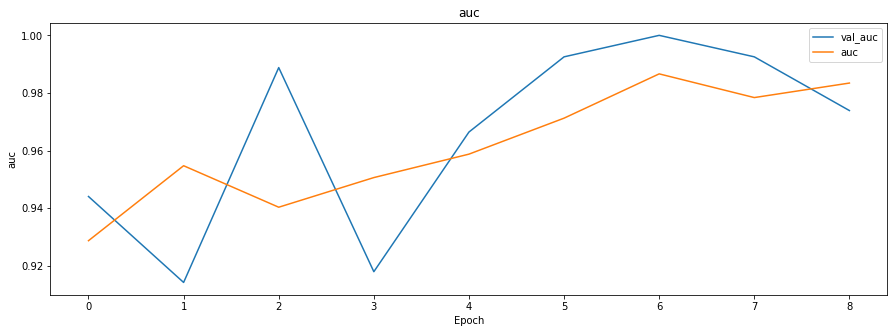

In [28]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_auc'],label='val_auc')
plt.plot(range(history.epoch[-1]+1),history.history['auc'],label='auc')
plt.title('auc'); plt.xlabel('Epoch'); plt.ylabel('auc');plt.legend(); 
plt.show()

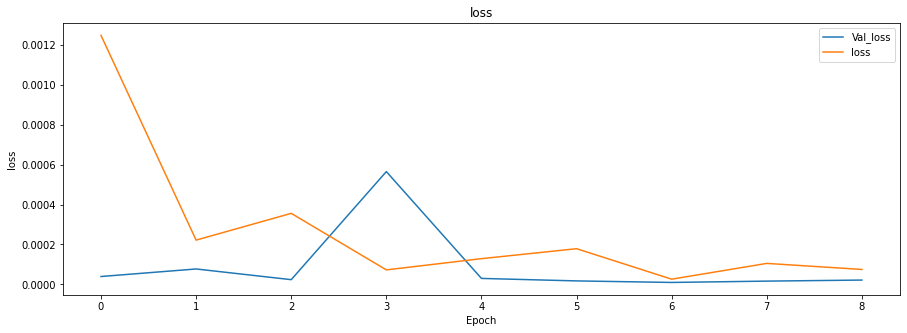

In [29]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='loss')
plt.title('loss'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

### ROC Curve

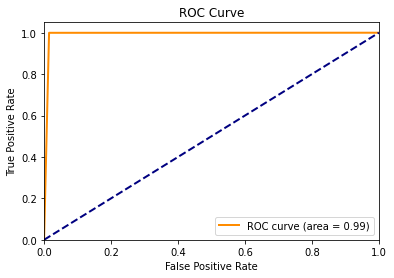

In [30]:
def generate_results(y_test, y_score):
    # print(y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
generate_results(y_test, y_pred)